✅ Loaded scaler and ONNX model
✅ Generated 6463 sequences
✅ Calculated anomaly scores
Recommended Critical Threshold: 18.622055
Recommended Warning Threshold: 4.605819
              precision    recall  f1-score   support

    Critical       0.08      0.47      0.13        17
     Warning       0.09      0.26      0.13        31
      Normal       1.00      0.97      0.99      6415

    accuracy                           0.97      6463
   macro avg       0.39      0.57      0.42      6463
weighted avg       0.99      0.97      0.98      6463



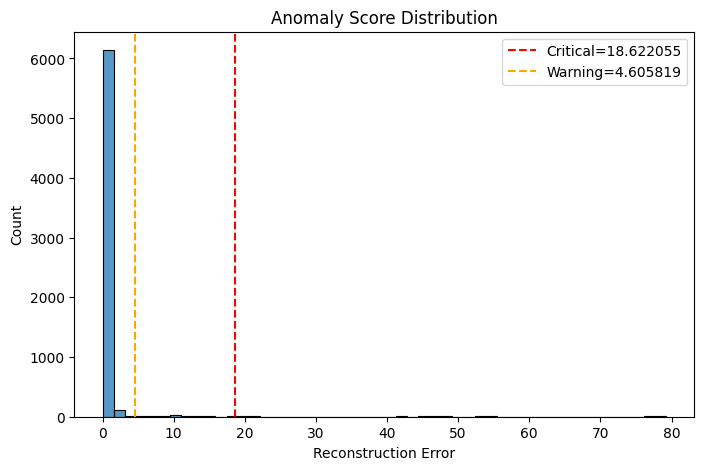

In [2]:
# ======================================================
# 1️⃣ Import Libraries
# ======================================================
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import onnxruntime as ort

# ======================================================
# 2️⃣ Configuration
# ======================================================
SEQUENCE_LENGTH = 30
NUMERICAL_COLS = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
LABEL_ORDER = ['Critical', 'Warning', 'Normal']
SCALER_PATH = 'scaler_fit.save'
ONNX_MODEL_PATH = 'lstm_autoencoder_model_opset11.onnx'
VALIDATION_FILES = ['./../../data/dev101_resample10T_flex.csv',
                    './../../data/dev102_resample10T_flex.csv']

# ======================================================
# 3️⃣ Helpers
# ======================================================
def create_sequences_by_device(df, seq_len, cols, return_index=False):
    sequences, device_ids, timestamps, indices = [], [], [], []
    scaled_cols = [f'scaled_{c}' for c in cols]
    for dev, grp in df.groupby('devID'):
        grp = grp.sort_values('timestamp')
        vals = grp[scaled_cols].values
        times = grp['timestamp'].values
        idxs = grp.index.values
        for i in range(len(vals) - seq_len + 1):
            sequences.append(vals[i:i+seq_len])
            device_ids.append(dev)
            timestamps.append(times[i+seq_len-1])
            if return_index:
                indices.append(idxs[i+seq_len-1])
    if return_index:
        return np.array(sequences, dtype=np.float32), device_ids, timestamps, indices
    return np.array(sequences, dtype=np.float32), device_ids, timestamps

def classify_risk(scores, crit_thr, warn_thr):
    conds = [scores > crit_thr,
             (scores <= crit_thr) & (scores > warn_thr),
             scores <= warn_thr]
    return np.select(conds, LABEL_ORDER, default='Normal')

def evaluate_thresholds(df, crit_thr, warn_thr):
    y_pred = classify_risk(df['anomaly_score'], crit_thr, warn_thr)
    y_true = df['true_label']
    f1_w = f1_score(y_true, y_pred, average='weighted', labels=LABEL_ORDER)
    f1_m = f1_score(y_true, y_pred, average='macro', labels=LABEL_ORDER)
    f1_c = f1_score(y_true, y_pred, average=None, labels=LABEL_ORDER)
    f1_min = f1_c.min()
    f1_h = len(f1_c) / np.sum(1.0 / (f1_c + 1e-8))
    return {'f1_weighted': f1_w, 'f1_macro': f1_m,
            'f1_per_class': f1_c, 'f1_min': f1_min,
            'f1_harmonic': f1_h, 'y_pred': y_pred}

# ======================================================
# 4️⃣ Load Scaler & ONNX Model
# ======================================================
scaler = joblib.load(SCALER_PATH)
session = ort.InferenceSession(ONNX_MODEL_PATH)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print("✅ Loaded scaler and ONNX model")

# ======================================================
# 5️⃣ Load and preprocess validation data
# ======================================================
frames = [pd.read_csv(f) for f in VALIDATION_FILES]
df_val = pd.concat(frames, ignore_index=True)
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_val = df_val.sort_values('timestamp').reset_index(drop=True)
df_val['label'] = df_val['label'].fillna('Normal')

# Scale features
scaled = scaler.transform(df_val[NUMERICAL_COLS])
for i, c in enumerate(NUMERICAL_COLS):
    df_val[f'scaled_{c}'] = scaled[:, i]

# Create sequences
X_val, dev_ids, times, idxs = create_sequences_by_device(df_val, SEQUENCE_LENGTH, NUMERICAL_COLS, return_index=True)
print(f"✅ Generated {len(X_val)} sequences")

# ======================================================
# 6️⃣ Run ONNX Inference
# ======================================================
def run_onnx_inference(session, sequences):
    scores = []
    for x in sequences:
        x_input = np.expand_dims(x, axis=0).astype(np.float32)  # (1, SEQUENCE_LENGTH, features)
        y_pred = session.run([output_name], {input_name: x_input})[0]
        mse = np.mean((x_input - y_pred)**2)
        scores.append(mse)
    return np.array(scores)

anom_scores = run_onnx_inference(session, X_val)
print("✅ Calculated anomaly scores")

# ======================================================
# 7️⃣ Build results DataFrame
# ======================================================
df_seq = pd.DataFrame({'devID': dev_ids, 'timestamp': times, 'index': idxs})
df_seq['true_label'] = df_val.loc[df_seq['index'], 'label'].replace(
    {'critical':'Critical','warning':'Warning','normal':'Normal'}).values
df_seq['anomaly_score'] = anom_scores
df_seq = df_seq[df_seq['true_label'].isin(LABEL_ORDER)]

# ======================================================
# 8️⃣ Threshold Optimization (Optional Grid Search)
# ======================================================
s_min, s_max = df_seq['anomaly_score'].min(), df_seq['anomaly_score'].max()
percentiles = np.linspace(0.1, 99.9, 200)
cands = np.percentile(df_seq['anomaly_score'], percentiles)
for p in [90,95,97,99]:
    v = np.percentile(df_seq['anomaly_score'], p)
    rng = s_max - s_min
    cands = np.concatenate([cands, v + np.array([-0.01,0,0.01])*rng])
cands = np.unique(np.clip(cands, s_min, s_max))

best = {'balanced': {'score':0}}
for crit in cands:
    for warn in cands:
        if warn >= crit: continue
        res = evaluate_thresholds(df_seq, crit, warn)
        bal = 0.6*res['f1_min'] + 0.4*res['f1_harmonic']
        if bal > best['balanced']['score']:
            best['balanced'].update({'score': bal, 'crit': crit, 'warn': warn, 'res': res})

opt = best['balanced']
print(f"Recommended Critical Threshold: {opt['crit']:.6f}")
print(f"Recommended Warning Threshold: {opt['warn']:.6f}")
print(classification_report(df_seq['true_label'], opt['res']['y_pred'], labels=LABEL_ORDER))

# ======================================================
# 9️⃣ Visualization
# ======================================================
def plot_results():
    plt.figure(figsize=(8,5))
    sns.histplot(df_seq['anomaly_score'], bins=50, kde=False)
    plt.axvline(opt['crit'], linestyle='--', color='red', label=f"Critical={opt['crit']:.6f}")
    plt.axvline(opt['warn'], linestyle='--', color='orange', label=f"Warning={opt['warn']:.6f}")
    plt.legend()
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Count")
    plt.show()

plot_results()
